In [20]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Housing prices in U.S. during the 2008 economic recession

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**plot 1** :compares housing prices in 'univerisity towns' versus 'non-univeristy towns'. It seems that univerisity towns were less affetced by recession i.e. housing prices in univerisity towns does not change much during the recession period. This observation therefore leads to the following hypothesis test.

**Hypothesis Test**: University towns have their mean housing prices less effected by recessions. To do this we run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`). The results conclude that the hypothesis is true and University towns were less effected by the recession.

**plot 2** :shows the geographic location of cities that have their mean housing prices most affected during recession in united states. Notably, almost all of these cities are located in Florida and California concentrating in coastal areas. The next step in the project is to do further analysis to see whether coastal cities were more affected by recession compared to non-coastal cities.

The following data files are available:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States)

In [2]:
# dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}


In [17]:
with open('university_towns.txt', 'r') as f:
        x = f.read().splitlines()
house = pd.read_csv('City_Zhvi_AllHomes.csv')

In [19]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. 
    The following cleaning is peprformed:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. remove newline character '\n'. '''
    with open('university_towns.txt', 'r') as f:
        x = f.read().splitlines()
        import re
    regex = re.compile('\(.+?\)') 
    regex2=re.compile('\[.+?\]') 
    for l in range(0,len(x)):
        x[l]= regex.sub('', x[l])
        x[l]= regex2.sub('', x[l])
    d={}
    for i in range(0,len(x)):
        if x[i] in state:
            st=x[i]
            d[st]=[]
            continue
        d[st].append(x[i])
    d
    dl=list(d.items())
    from pandas import Series
    df=pd.DataFrame(dl, columns=['State', 'Town'])
    df = df[['Town', 'State']]
    b=pd.concat([Series(row['State'], row['Town'])              
                    for _, row in df.iterrows()]).reset_index()
    b.columns = ['RegionName', 'State']
    b = b[['State', 'RegionName']]
    b['RegionName']=b['RegionName'].str.rstrip()
    b['RegionName'] = b['RegionName'].replace({"Pomona  and formerly Pomona College": "Pomona","Carrollton *Dahlonega": "Carrollton",
                                                   "Lexington (University of Kentucky, Transylvania University": "Lexington",
                                                   "Springfield , , and": "Springfield", "Waltham ,":"Waltham", 
                                               "Duluth (University of Minnesota Duluth, Lake Superior College, The College of St. Scholastica, University of Wisconsin–Superior, Duluth Business University": "Duluth",
                                              "Mankato , Bethany Lutheran College":"Mankato", "Fulton .": "Fulton", "Ewing ,":"Ewing", 
                                               "Jersey City ,":"Jersey City", "Madison , ,":"Madison", "Newark , ,":"Newark", 
                                              })
    b['RegionName'][414] = 'Providence'
    return b



In [22]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. 
    '''
    house = pd.read_csv('City_Zhvi_AllHomes.csv')
    house=house.drop(house.columns[[range(6,51)]],axis=1).drop(house.columns[[0,3,4,5]],axis=1)
    house["State"] = house["State"].map(states)
    house.set_index(['State', 'RegionName'], inplace=True)
    house.columns = pd.to_datetime(house.columns)
    res = house.resample('Q', axis=1).mean()
    res = res.rename(columns=lambda col: '{}q{}'.format(col.year, col.quarter))
    res
    return res


In [24]:
df=convert_housing_data_to_quarters()
start='2008q3'
bottom='2009q2'
unilist=get_list_of_university_towns()
unilist.set_index(['State', 'RegionName'], inplace=True)
df['price_ratio']=df[start]/df[bottom]
join=pd.merge(unilist, df, how='inner', left_index=True, right_index=True)
join.dropna(subset=['price_ratio'], inplace=True)
unitown=join['price_ratio']
nonunidf=df[~df.index.isin(unitown.index)]
nonunidf.dropna(subset=['price_ratio'], inplace=True)
nonuni=nonunidf['price_ratio']

c:\users\elysh\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Text(4.5,5e+06,'Recession Period')

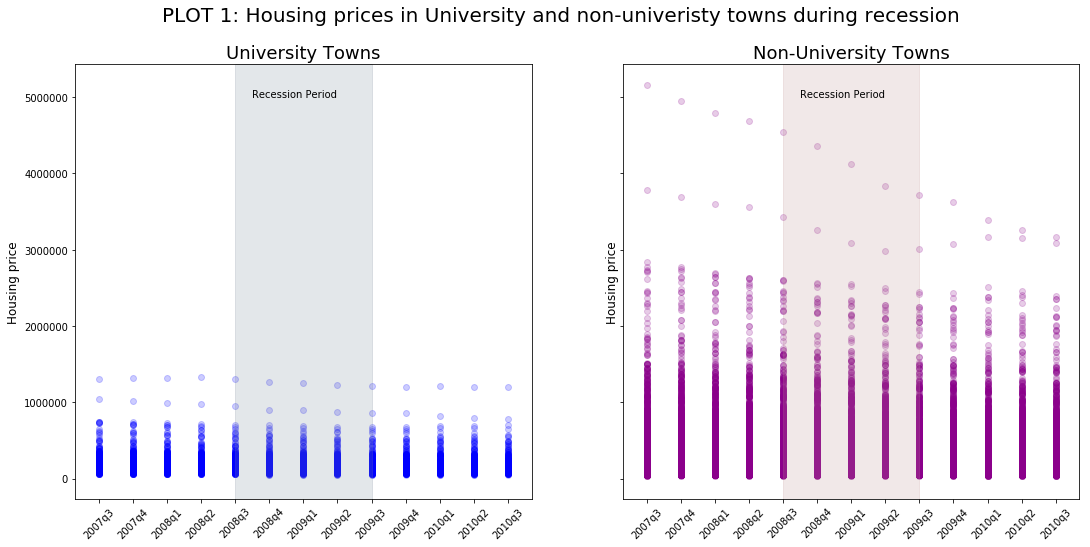

In [31]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, sharey=True,figsize=(18,8))
fig.suptitle("PLOT 1: Housing prices in University and non-univeristy towns during recession", fontsize=20)
for i, (name, value) in enumerate(join[join.columns[30:43]].iteritems()):
    ax1.scatter([i]*len(value), value, color='b', alpha=0.2)
ax1.set_xticks(range(len(join[join.columns[30:43]].columns)))
ax1.set_xticklabels(join[join.columns[30:43]].columns)
ax1.set_title('University Towns',fontsize =18)
ax1.set_ylabel('Housing price',fontsize = 12)
ax1.axvspan(4, 8, alpha=0.2, color='lightslategrey')
ax1.annotate('Recession Period', xy=(4.5, 5000000), xytext=(4.5, 5000000),fontsize =10)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for i, (name, value) in enumerate(nonunidf[nonunidf.columns[30:43]].iteritems()):
    ax2.scatter([i]*len(value), value, color='darkmagenta',alpha=0.2)
ax2.set_xticks(range(len(nonunidf[nonunidf.columns[30:43]].columns)))
ax2.set_xticklabels(nonunidf[nonunidf.columns[30:43]].columns);
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
ax2.set_title('Non-University Towns',fontsize =18)
ax2.set_ylabel('Housing price',fontsize = 12)
ax2.axvspan(4, 8, alpha=0.2, color='rosybrown')
ax2.annotate('Recession Period', xy=(4.5, 5000000), xytext=(4.5, 5000000),fontsize =10)

In [27]:
most_drop=df.sort_values(by=['price_ratio'],ascending=False)[:150]
least_drop=df.sort_values(by=['price_ratio'])[:150]
ratio=most_drop['price_ratio']
dd=most_drop.reset_index()
citistate=dd['RegionName']+[', ']+dd['State']

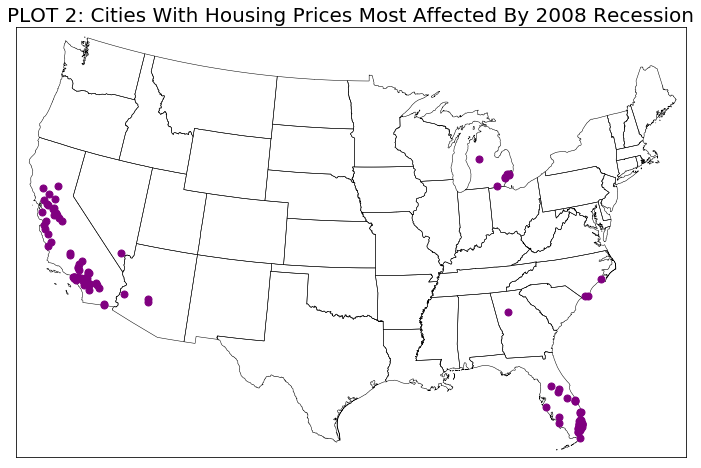

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

scale = 7
plt.figure(figsize=(12,8))
plt.title('PLOT 2: Cities With Housing Prices Most Affected By 2008 Recession',fontsize=20)
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
map.readshapefile('st99_d00', name='states', drawbounds=True)

# Get the location of each city and plot it
geolocator = Nominatim(timeout=10)
for (city,count) in zip(citistate, ratio):
    loc = geolocator.geocode(city)
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='o',color='Purple',markersize=int(math.sqrt(count))*scale)
plt.show()

In [114]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (reject the null hypothesis), or different=False if 
    otherwise (cannot reject the null hypothesis).  The
    value for better is either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    df=convert_housing_data_to_quarters()
    start=get_recession_start()
    bottom=get_recession_bottom()
    unilist=get_list_of_university_towns()
    unilist.set_index(['State', 'RegionName'], inplace=True)
    df['price_ratio']=df[start]/df[bottom]
    join=pd.merge(unilist, df, how='inner', left_index=True, right_index=True)
    join.dropna(subset=['price_ratio'], inplace=True)
    unitown=join['price_ratio']
    nonunidf=df[~df.index.isin(unitown.index)]
    nonunidf.dropna(subset=['price_ratio'], inplace=True)
    nonuni=nonunidf['price_ratio']
    from scipy import stats
    (st, p)=stats.ttest_ind(unitown, nonuni)
    different=False
    better="non-university town"
    if p<0.01:
        different=True
    if unitown.mean()<nonuni.mean():
        better="university town"
    
    return (different, p, better)
run_ttest()

c:\users\elysh\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(True, 0.005496427353693887, 'university town')